<a href="https://colab.research.google.com/github/yassermb/DL_STRUCT/blob/main/deeplearning_proteinstructure_AlgoSB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING FOR PROTEIN STRUCTURES

## Classification of handwritten digits

<img src='https://drive.google.com/uc?id=16D9YOSCco-qMAC7moItDzasEkP-dV78h'>

We want to produce a simple Convolutional Neural Network (CNN) architecture in Keras to classify the handwritten digits in the MNIST database.

**A visualisation on how convolutional filters scan an image is shown [here](https://cs231n.github.io/assets/conv-demo/index.html)**

This code assume your already have installed <code>numpy</code>, <code>keras</code>, <code>tensorflow</code>, ... on your computer. If not, uncomment the adequate lines in the cell below:

In [4]:
import sys
print('Your python version: {}'.format(sys.version_info.major))
# Uncomment lines below only if you need them 
#!{sys.executable} -m pip install -U numpy --user
#!{sys.executable} -m pip install -U matplotlib --user
#!{sys.executable} -m pip install -U keras --user
#!{sys.executable} -m pip install -U tensorflow --user
#!{sys.executable} -m pip install -U theano --user

Your python version: 3


In [5]:
USE_TENSORFLOW_AS_BACKEND = True

# IF YOU *DO* HAVE AN Nvidia GPU on your computer, or execute on Google COLAB, then change below to False!
FORCE_CPU = False 

In [6]:
import os
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

In [7]:
if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
import keras
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values

In [9]:
#if USE_TENSORFLOW_AS_BACKEND:
#    K.common.set_image_dim_ordering("tf")
#else:
#    K.set_image_dim_ordering("th")

In [10]:
print('Your keras version: {}'.format(keras.__version__))
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
    print("GPU : "+tensorflow.test.gpu_device_name())
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your keras version: 2.7.0
Your tensorflow version: 2.7.0
GPU : /device:GPU:0


In [11]:
# --------------------------------------
# Dataset variables
# --------------------------------------
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000  # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 with 1 channel (greyscale)
num_classes = 10                 # there are 10 classes (1 per digit)

# --------------------------------------
# Dataset loading & preprocessing
# --------------------------------------
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range


X_train = X_train[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, newaxis, :, :] # Reshape in "convolutionable" format (add tensor dim for the depth)

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

print(X_train.shape, Y_train.shape)

(60000, 1, 28, 28) (60000, 10)


In [12]:
# --------------------------------------
# Network params
# --------------------------------------

batch_size = 32    # in each iteration, we consider 32 training examples at once
num_epochs = 15    # we iterate 15 times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.   # dropout after pooling with probability 0.
drop_prob_2 = 0.   # dropout in the FC layer with probability 0.
hidden_size = 128  # the FC layer will have 128neurons
weight_penalty = 0. # Factor for weights penalty

# --------------------------------------
# CNN network definition
# --------------------------------------
# inp = Input(shape=(1,height,width)) # greyscale --> depth==1
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential()
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_first", input_shape=( 1, 28, 28)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 28, 28)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 14, 28)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 14, 28)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 14, 16)         11216     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 7, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 7, 16)          0

## Questions

#### What are the activation functions here? Why are they chosen?
#### What is the loss function?
#### What is the value of learning rate here?


In [13]:
# --------------------------------------
# Loss function and Optimizer
# --------------------------------------
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.4) # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

Epoch 1/15
1125/1125 [==============================] - 38s 7ms/step - loss: 0.3119 - accuracy: 0.9047 - val_loss: 0.1337 - val_accuracy: 0.9593
Epoch 2/15
1125/1125 [==============================] - 7s 6ms/step - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.0955 - val_accuracy: 0.9700
Epoch 3/15
1125/1125 [==============================] - 8s 7ms/step - loss: 0.0757 - accuracy: 0.9761 - val_loss: 0.0901 - val_accuracy: 0.9722
Epoch 4/15
1125/1125 [==============================] - 7s 7ms/step - loss: 0.0634 - accuracy: 0.9805 - val_loss: 0.0813 - val_accuracy: 0.9754
Epoch 5/15
1125/1125 [==============================] - 7s 6ms/step - loss: 0.0497 - accuracy: 0.9839 - val_loss: 0.0796 - val_accuracy: 0.9769
Epoch 6/15
1125/1125 [==============================] - 7s 7ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.0927 - val_accuracy: 0.9725
Epoch 7/15
1125/1125 [==============================] - 7s 7ms/step - loss: 0.0371 - accuracy: 0.9873 - val_loss: 0.0726 - val_accuracy

## Questions
#### What is an Epoch?
#### What is the difference between Epoch and Batch?
#### Which one of the following training approaches implemented in this code?
- Batch Gradient Descent. Batch Size = Size of Training Set
- Stochastic Gradient Descent. Batch Size = 1
- Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**

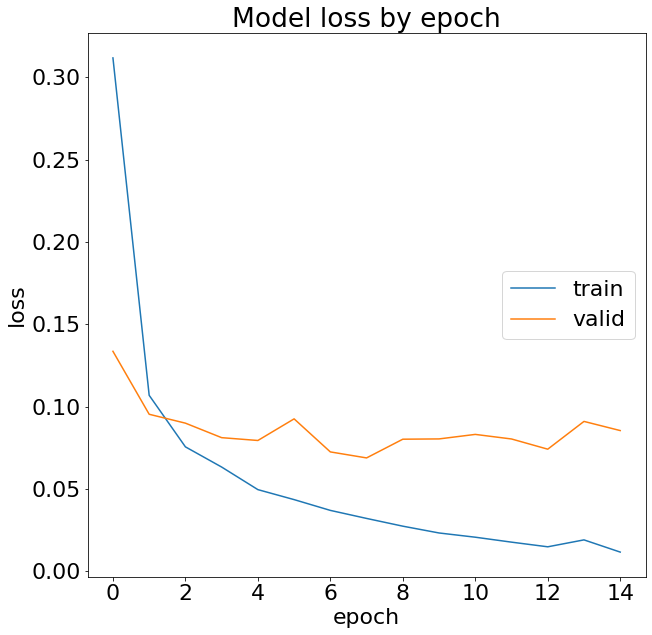

In [14]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Clear all the variables and free your RAM.

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Amino acid and its environment

### 1. Can you recognize the amino acid by its structure?

Take a look at the following structures of amino acids. Can you distinguish different amino acids? This table of amino acids might help you in this task.
- Nitrogen: Blue
- Carbon: Green
- Oxygen: Red
- Sulfur: Yellow

<img src='https://drive.google.com/uc?id=1cltgrjlxVcVkx-TffmExqvBq7jpHxN_L'>

Now take a look at the following amino acids and recognize which structure they belong to.

<img src='https://drive.google.com/uc?id=14TWwgKaHNAjMHyF5Nae_yOT_jI5jkQjC'>

It was easy! no? 
- Did the rotation of the amino acids or changes in the side-chain and backbon torsion angles influence your decisions? 
- What deep learning approach do you propose for the classification of amino acids structures?
- Does traditional CNN do the job for us?

### 2. The environment around residue

<img src='https://drive.google.com/uc?id=1EA0YTjQV_GJsoJyD_TQ-tm2Puo7SXQWJ'>

- 6M0J is a crystal structure of SARS-CoV-2 spike receptor-binding domain (RBD) in interaction with Angiotensin-Converting Enzyme 2 (ACE2). 

- Download the structure of biological assembly of this complex and visualize it in pymol.

- By what experimental method the structure of this complex is determined?

- Select spike glycoprotein (it's chain E). You can do this using command `select Spike, chain E`.

- Select ACE2 (it's chain A). You can do this using command `select ACE2, chain A`.

- Can you identify the interface between these two chains?

- Select residue 382 from chain A and rename it to `centralRes`. Use command `set_name sele, centralRes`. What is the name of this residue and what are its characteristics?

- Represent this residue with spheres using commands `show spheres, centralRes` and `set sphere_scale, 0.6`.

- Select the environment around this residue (6 $Å$) and name it `env`. Use command `select env, byres(centralRes around 6) + centralRes`.

- Show `env` as sticks. Use command `show sticks, env`.

- From the action menu (A) on `env` orient the visualisation on it.

- From the action menu (A) on `env` find all the polar contacts. `file->polar contacts->whitin selection`.

- Analyze the environment.

- Now repeat the same process for residue 487, 489, 498, and 500 from chain E.

- Present the protein in using balls and sticks

- Select a residue from the interface and change its torsion angles.


## A simple application: prediction of amino acid from its environment

### 1. Locally oriented cubes

A cube with the size of 24×24×24 $Å^3$ is placed on the residue and oriented according to the its backbone structure. Therefore, the architecture is invariant to 3D translations and rotations.

<img src='https://drive.google.com/uc?id=1cuaiYUTfhJwTeJzahumJKlySjV_an0Aa'>

<br>
<br>
<br>

For better understanding of the properties of locally oriented cubes please review [this article](https://academic.oup.com/bioinformatics/article/35/18/3313/5341430?login=true).

### 2. An end-to-end architecture to predict the amino acid from the environment

In [1]:
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from scipy import interp
from math import exp
from random import shuffle, random, seed, sample
import matplotlib.pyplot as plt
import time
import os, sys
import glob

!pip install pickle5
import pickle5

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, Dense, Dropout, Activation, Flatten, Concatenate, Dot, BatchNormalization, Add, Lambda
from tensorflow.keras.backend import ones, ones_like
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, log_loss
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
logging.basicConfig(filename='manager.log', filemode='w', format='%(levelname)s: %(message)s', level=logging.DEBUG)
mainlog = logging.getLogger('main')
logging.Logger

logging.Logger

In [3]:
print('Your python version: {}'.format(sys.version_info.major))

Your python version: 3


In [4]:
USE_TENSORFLOW_AS_BACKEND = True
FORCE_CPU = False

if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
    print("GPU : "+tensorflow.test.gpu_device_name())
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your tensorflow version: 2.7.0
GPU : /device:GPU:0


#### 2.1 Model architecture based on 3D CNN

In [6]:
def Conv_3D_model(input_shape):
  hidden_size1 = 200
  hidden_size2 = 20
   
  X_in = Input(shape=input_shape)
  
  H = Conv3D(20, kernel_size=(1, 1, 1), use_bias = True, padding = 'valid', activation='linear', kernel_initializer='he_uniform', input_shape=X_in.shape)(X_in)
  H = BatchNormalization()(H)
  H = Conv3D(20, kernel_size=(3, 3, 3), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = Conv3D(30, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = Conv3D(20, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size=(4, 4, 4), strides=(4, 4, 4))(H)
  H = Flatten()(H)
  H = Dropout(0.4)(H)
  
  H = Dense(hidden_size1, activation='elu', name='layer1', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.2)(H)
  
  H = Dense(hidden_size2, activation='elu', name='layer2', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.1)(H)
  
  Y = Dense(20, activation='softmax')(H)
  
  _model = Model(inputs=[X_in], outputs=Y)
  _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
  _model.summary()
  return _model

#### Questions
- What does the first layer of Conv3D do?
- What activation functions are used in this architecture?
- What is the difference between ELU and ReLU activation functions?
- What cost function are we trying to minimize?
- How many convolutional layers are used in this architecture?
- On which layers dropout technique is used? I invite you to review this [page](https://jmlr.org/papers/v15/srivastava14a.html).

#### 2.2 The input data: locally oriented cubes

Functions to serializing and de-serializing pickle object structure.

In [7]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle5.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

In [8]:
def load_map(train_path):
    X_train, y_train, res_name = load_obj(train_path.replace('.pkl',''))
    return X_train, y_train, res_name

Download two datasets: residue samples with their environments and residue samples without their environments.

In [24]:
!gdown --id '1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP'
!gdown --id '1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd'

Downloading...
From: https://drive.google.com/uc?id=1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP
To: /content/traindata_30.zip
100% 8.90M/8.90M [00:00<00:00, 78.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd
To: /content/traindata_env_30.zip
100% 80.9M/80.9M [00:00<00:00, 157MB/s]


Decompress the two datasets.

In [25]:
!unzip '/content/traindata_30.zip'
!unzip '/content/traindata_env_30.zip'

Archive:  /content/traindata_30.zip
replace traindata_30/ALA_1cju_0_1_A_1--1cju_0_1_B_1_10.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: traindata_30/ALA_1cju_0_1_A_1--1cju_0_1_B_1_10.pkl  
  inflating: traindata_30/ALA_1h4r_0_1_A_1--1h4r_0_1_B_1_17.pkl  
  inflating: traindata_30/ALA_1ixm_0_1_A_1--1ixm_0_1_B_1_31.pkl  
  inflating: traindata_30/ALA_1l9r_0_1_A_1--1l9r_0_1_C_1_58.pkl  
  inflating: traindata_30/ALA_1n1e_0_1_A_1--1n1e_0_1_B_1_98.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_67.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_68.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_12.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_70.pkl  
  inflating: traindata_30/ALA_1su6_0_1_A_2--1su6_0_1_A_1_35.pkl  
  inflating: traindata_30/ALA_1yi1_0_1_A_4--1yi1_0_1_A_1_169.pkl  
  inflating: traindata_30/ALA_1yu2_0_1_A_3--1yu2_0_1_A_2_12.pkl  
  inflating: traindata_30/ALA_1zv8_0_2_I_1--1zv8_0_2_G_1_2.pkl  
  infl

Load the samples of the residues with or without their environments.

In [17]:
#samples = glob.glob(os.path.join('traindata_30', '*.pkl'))
samples = glob.glob(os.path.join('traindata_env_30', '*.pkl')) #We will use this line in the end!

In [ ]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in samples:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  X.append(np.array(sample_X))
  y.append(np.array(sample_y))
X = np.array(X)
y = np.array(y)

Loading traindata_env_30/LEU_5vb0_0_4_G_1--5vb0_0_4_H_1_15.pkl
Loading traindata_env_30/ALA_3zpg_0_1_A_2--3zpg_0_1_A_1_65.pkl
Loading traindata_env_30/ASP_2bnu_0_1_A_1--2bnu_0_1_B_1_30.pkl
Loading traindata_env_30/ASP_1csr_0_1_A_2--1csr_0_1_A_1_17.pkl
Loading traindata_env_30/ASP_4dl0_0_1_K_1--4dl0_0_1_J_1_68.pkl
Loading traindata_env_30/ASP_3zpg_0_1_A_2--3zpg_0_1_A_1_46.pkl
Loading traindata_env_30/ASP_1meh_0_1_A_1--1meh_0_1_A_3_17.pkl
Loading traindata_env_30/THR_2vic_0_1_B_1--2vic_0_1_A_1_64.pkl
Loading traindata_env_30/ARG_1pf9_0_1_R_1--1pf9_0_1_Q_1_25.pkl
Loading traindata_env_30/LYS_1h8e_0_1_G_1--1h8e_0_1_I_1_37.pkl
Loading traindata_env_30/TRP_5ioq_0_1_B_1--5ioq_0_1_A_1_50.pkl
Loading traindata_env_30/PRO_1viv_0_2_A_1--1viv_0_2_A_2_13.pkl
Loading traindata_env_30/GLU_2r5n_0_1_A_1--2r5n_0_1_B_1_74.pkl
Loading traindata_env_30/ARG_5ioq_0_1_B_1--5ioq_0_1_A_1_65.pkl
Loading traindata_env_30/ASP_5v5k_0_1_F_2--5v5k_0_1_G_2_16.pkl
Loading traindata_env_30/PHE_5ioq_0_1_B_1--5ioq_0_1_A_1

#### 2.3 Split data into train and test sets

In [ ]:
seed(int(np.round(np.random.random()*10)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
del X, y
print(X_test.shape)

#### 2.4 Training Process

In [ ]:
num_epochs = 20
batch_size = 10
v_dim = 24
n_features = 167

In [ ]:
input_shape=(v_dim,v_dim,v_dim,n_features)
model = Conv_3D_model(input_shape)

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, y_train, # Train the model using the training set...
                    batch_size=batch_size, epochs=num_epochs,
                    verbose=1, validation_split=0.3) # ...holding out 30% of the data for validation

In [ ]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Question: Is this evaluation of the performance reliable?

#### 2.5 Let's take a look at the performance of the model on test samples.

In [ ]:
list_aa = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 
           'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG', 
           'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']
list_aa.sort()

plt.rcParams.update({'font.size': 22})

def do_pdf(pred, aa, ll):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    barlist = ax.bar(range(len(list_aa)), pred, color='gray', label='Log-loss: ' + str(ll))
    
    ax.set_xticks(range(len(list_aa)))
    ax.set_xticklabels(list_aa, rotation='-90')
    
    barlist[pred.index(max(pred))].set_color('r')
    barlist[list_aa.index(aa)].set_color('g')

    ax.set_title(aa)
    ax.set_ylabel('Probability')
    ax.set_ylim(0,1)

    plt.tight_layout()
    plt.legend()
    plt.show()

for i in range(10):
  ind = np.random.choice(range(len(X_test)))
  X_t = np.array([X_test[ind]])
  y_t = y_test[ind]
  aa = list_aa[np.argwhere(y_t==1)[0][0]]
  pred = model.predict(X_t, batch_size=X_t.shape[0])[0]
  ll = round(log_loss(y_t, pred), 3)
  do_pdf(list(pred), aa, ll)

In [ ]:
#Clean the memory!
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
#model = None

#### 2.5 Memorizing versus learning: not too similar not too different!
- Interpret the results. How is the performance of the machine?
- Now repeat the same process but this time load the residue samples with their environments. 

#### 2.6 Discussion
What are the applications of such a model? 

### 3. Transfer learning: use the trained model for a new downstream task

Now we want to use the model you have just trained to evaluate the environment of a residue. In this task we have two classes 0 and 1. Class 1 means the residue is comfortable in its environment (the environment is an acceptable local frame for the arrangment of the atoms) and class 0 means otherwise.

In [ ]:
#Clean the memory!
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]

#### 3.1 The input data: locally oriented cubes representing acceptable and incorrect environments

Download the dataset: residue samples with their environments and 0 or 1 as target labels.

In [ ]:
!gdown --id '1p4v821pVgICBnWudFIuScFjPFiCzrF4F'

Decompress the dataset.

In [ ]:
!unzip '/content/traindata_env_class01.zip'

Load the samples of the residues with target value 1 and 0.

In [ ]:
samples_0 = glob.glob(os.path.join('traindata_env_class01', '0', '*'))
samples_1 = glob.glob(os.path.join('traindata_env_class01', '1', '*'))

In [ ]:
samples = samples_1 + samples_0
shuffle(samples)

In [ ]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in samples_1[:25]:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  X.append(np.array(sample_X))
  y.append(1)
for sample in samples_0[:25]:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  X.append(np.array(sample_X))
  y.append(0)
X = np.array(X)
y = np.array(y)

#### 3.2 Split data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
del X, y
print(X_test.shape)

#### 3.3 Use the pre-trained model as feature extractor
Fot this purpose we will create an intermediate model similar to the pre-trained one except its output is the neurons of the second hidden layer of the fully connected network (`layer2`).

In [ ]:
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('layer2').output)

Now we extract rich features from the train and test sets.

In [ ]:
X_train_tr = intermediate_model.predict(X_train)

In [ ]:
X_test_tr = intermediate_model.predict(X_test)

#### 3.4 Training Process
Define a downstream model to classify the environments. This model can be non-linear such as a neural network or a linear model such as logistic regression.

In [ ]:
def nn_model(input_shape):
    hidden_size1 = 10
    hidden_size2 = 5
    X_in = Input(shape=input_shape)
    H = Dense(hidden_size1, activation='elu', name='layer1')(X_in)
    H = Dense(hidden_size2, activation='elu', name='layer2')(H)
    Y = Dense(1, activation='sigmoid')(H)
    _model = Model(inputs=X_in, outputs=Y)
    _model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
    _model.summary()
    return _model

In [ ]:
num_epochs = 20
batch_size = 10
n_features_tr = 20 #hidden_size2 of the pre-trained model

In [ ]:
input_shape=(n_features_tr)
model_tr = nn_model(input_shape)

# --------------------------------------
# Training
# --------------------------------------
history = model_tr.fit(X_train_tr, y_train, # Train the model using the training set...
                    batch_size=batch_size, epochs=num_epochs,
                    verbose=1, validation_split=0.3) # ...holding out 30% of the data for validation

In [ ]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()

In [ ]:
noskill = [0]*len(y_test)
y_pred = model_tr.predict(X_test_tr)
roc_auc = roc_auc_score(y_test, y_pred)
print('Transferred learning ROC AUC %.3f' % roc_auc)

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='NoSkill')
plt.plot(fpr, tpr, linestyle='-', label='Transferred Learning')
plt.show()

#plot_roc_curve(y_test, naive_probs, y_pred)

#### 3.5 Discussion

Designed by Yasser MOHSENI BEHBAHANI, LCQB, Sorbonne Université, 2021

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>
